In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])

print("First 5 rows:")
display(df.head())

print("\nMissing Values:")
print(df.isnull().sum())

df['Class'] = df['Class'].map({'Kecimen':0, 'Besni':1})

X = df.drop("Class", axis=1)
y = df["Class"]

mi = mutual_info_classif(X, y, random_state=42)
mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_scores)

least_important = mi_scores.index[-1]
print(f"\nDropping least important feature: {least_important}")
X = X.drop(columns=[least_important])

Saving Raisin_Dataset.csv to Raisin_Dataset.csv
First 5 rows:


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen



Missing Values:
Area               0
MajorAxisLength    0
MinorAxisLength    0
Eccentricity       0
ConvexArea         0
Extent             0
Perimeter          0
Class              0
dtype: int64

Mutual Information Scores:
Perimeter          0.358507
MajorAxisLength    0.348341
ConvexArea         0.297530
Area               0.277582
MinorAxisLength    0.134869
Eccentricity       0.129117
Extent             0.029344
dtype: float64

Dropping least important feature: Extent


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Helper function for evaluation
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n{name} Classification Report:\n")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}

results = []


In [ ]:
# 2) BAGGING CLASSIFIER
bag = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)
bag.fit(X_train, y_train)
results.append(evaluate_model("Bagging", bag, X_test, y_test))

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_samples": [0.5, 0.7, 1.0],
    "max_features": [0.5, 1.0],
    "estimator__max_depth": [None, 3, 5],
}
grid_bag = GridSearchCV(bag, param_grid, cv=3, n_jobs=-1, scoring="f1")
grid_bag.fit(X_train, y_train)
print("\nBest Bagging Params:", grid_bag.best_params_)
results.append(evaluate_model("Bagging (Tuned)", grid_bag.best_estimator_, X_test, y_test))


Bagging Classification Report:

[[80 10]
 [18 72]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85        90
           1       0.88      0.80      0.84        90

    accuracy                           0.84       180
   macro avg       0.85      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180


Best Bagging Params: {'estimator__max_depth': None, 'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200}

Bagging (Tuned) Classification Report:

[[81  9]
 [17 73]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86        90
           1       0.89      0.81      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180




Random Forest Classification Report:

[[81  9]
 [15 75]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        90
           1       0.89      0.83      0.86        90

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180


Best RF Params: {'max_depth': 10, 'max_features': 0.7, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest (Tuned) Classification Report:

[[81  9]
 [16 74]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        90
           1       0.89      0.82      0.86        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



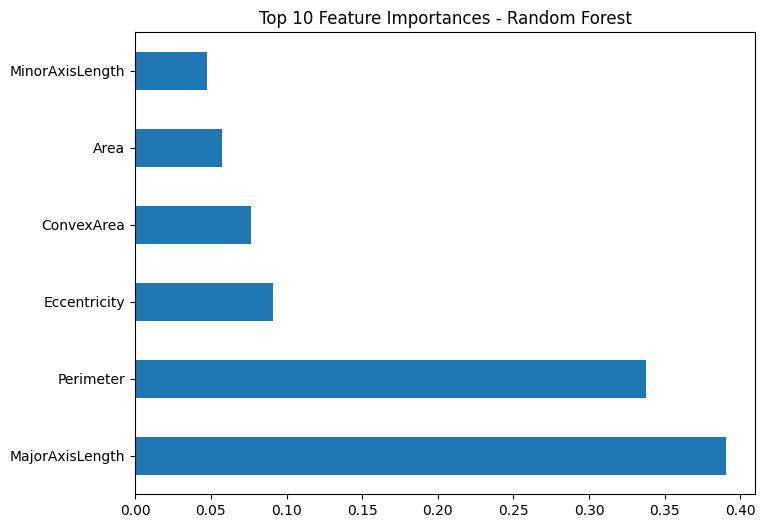

In [ ]:
# 3) RANDOM FOREST
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
results.append(evaluate_model("Random Forest", rf, X_test, y_test))

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2", 0.7],
}
grid_rf = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, scoring="f1")
grid_rf.fit(X_train, y_train)
print("\nBest RF Params:", grid_rf.best_params_)
best_rf = grid_rf.best_estimator_
results.append(evaluate_model("Random Forest (Tuned)", best_rf, X_test, y_test))

feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind="barh", figsize=(8,6))
plt.title("Top 10 Feature Importances - Random Forest")
plt.show()



In [ ]:
# 4) ADABOOST
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
ada.fit(X_train, y_train)
results.append(evaluate_model("AdaBoost", ada, X_test, y_test))

param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 1.0],
    "estimator__max_depth": [1, 2],
}
grid_ada = GridSearchCV(ada, param_grid, cv=3, n_jobs=-1, scoring="f1")
grid_ada.fit(X_train, y_train)
print("\nBest AdaBoost Params:", grid_ada.best_params_)
results.append(evaluate_model("AdaBoost (Tuned)", grid_ada.best_estimator_, X_test, y_test))


AdaBoost Classification Report:

[[82  8]
 [12 78]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        90
           1       0.91      0.87      0.89        90

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180


Best AdaBoost Params: {'estimator__max_depth': 2, 'learning_rate': 1.0, 'n_estimators': 50}

AdaBoost (Tuned) Classification Report:

[[82  8]
 [17 73]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87        90
           1       0.90      0.81      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



In [ ]:
# 5) GRADIENT BOOSTING
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
results.append(evaluate_model("Gradient Boosting", gb, X_test, y_test))

param_grid = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [2, 3, 5],
    "subsample": [0.8, 1.0],
}
grid_gb = GridSearchCV(gb, param_grid, cv=3, n_jobs=-1, scoring="f1")
grid_gb.fit(X_train, y_train)
print("\nBest GradientBoost Params:", grid_gb.best_params_)
results.append(evaluate_model("Gradient Boosting (Tuned)", grid_gb.best_estimator_, X_test, y_test))



Gradient Boosting Classification Report:

[[78 12]
 [14 76]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86        90
           1       0.86      0.84      0.85        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180


Best GradientBoost Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Gradient Boosting (Tuned) Classification Report:

[[83  7]
 [13 77]]
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        90
           1       0.92      0.86      0.89        90

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180



In [ ]:
# 6) VOTING CLASSIFIER
log_clf = LogisticRegression(max_iter=500)
voting_hard = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", best_rf), ("gb", grid_gb.best_estimator_)],
    voting="hard"
)
voting_hard.fit(X_train, y_train)
results.append(evaluate_model("Voting (Hard)", voting_hard, X_test, y_test))

voting_soft = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", best_rf), ("gb", grid_gb.best_estimator_)],
    voting="soft"
)
voting_soft.fit(X_train, y_train)
results.append(evaluate_model("Voting (Soft)", voting_soft, X_test, y_test))


Voting (Hard) Classification Report:

[[83  7]
 [12 78]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.90        90
           1       0.92      0.87      0.89        90

    accuracy                           0.89       180
   macro avg       0.90      0.89      0.89       180
weighted avg       0.90      0.89      0.89       180


Voting (Soft) Classification Report:

[[82  8]
 [13 77]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        90
           1       0.91      0.86      0.88        90

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180



In [ ]:
# 7) STACKING CLASSIFIER
stacking = StackingClassifier(
    estimators=[
        ("knn", KNeighborsClassifier()),
        ("rf", best_rf),
        ("gb", grid_gb.best_estimator_)
    ],
    final_estimator=LogisticRegression(max_iter=500)
)
stacking.fit(X_train, y_train)
results.append(evaluate_model("Stacking", stacking, X_test, y_test))



Stacking Classification Report:

[[82  8]
 [13 77]]
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        90
           1       0.91      0.86      0.88        90

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180



,Model,Accuracy,Precision,Recall,F1
0,Bagging,0.844444,0.878049,0.800000,0.837209
1,Bagging (Tuned),0.855556,0.890244,0.811111,0.848837
2,Random Forest,0.866667,0.892857,0.833333,0.862069
3,Random Forest (Tuned),0.861111,0.891566,0.822222,0.855491
4,AdaBoost,0.888889,0.906977,0.866667,0.886364
5,AdaBoost,0.888889,0.906977,0.866667,0.886364
6,AdaBoost (Tuned),0.861111,0.901235,0.811111,0.853801
7,Gradient Boosting,0.855556,0.863636,0.844444,0.853933
8,Gradient Boosting (Tuned),0.888889,0.916667,0.855556,0.885057
9,Voting (Hard),0.894444,0.917647,0.866667,0.891429


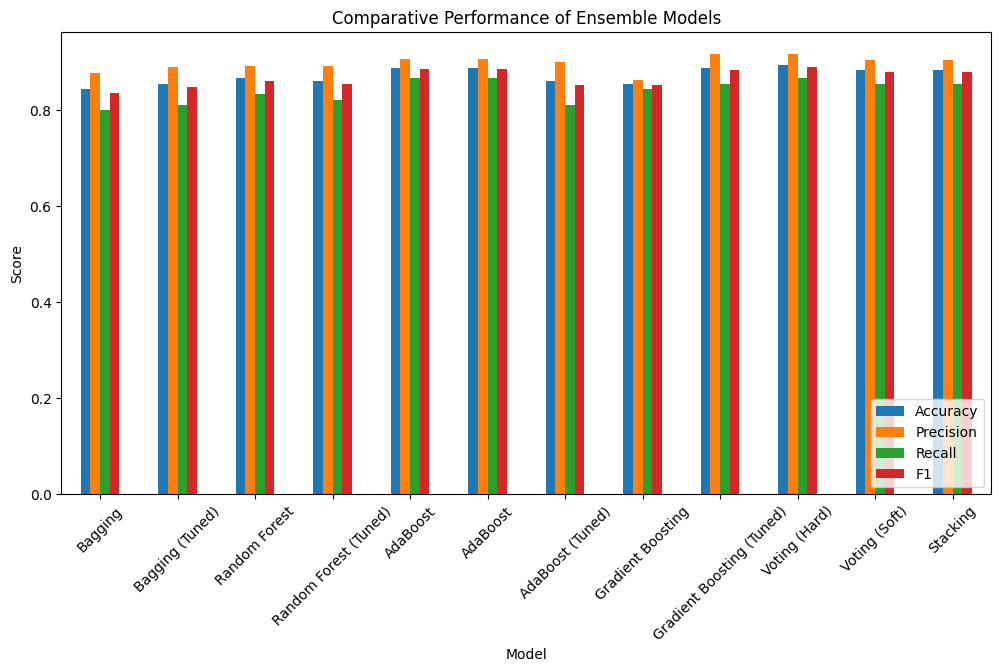

In [ ]:
# 8) COMPARATIVE ANALYSIS
results_df = pd.DataFrame(results)
display(results_df)

results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1"]].plot(
    kind="bar", figsize=(12,6)
)
plt.title("Comparative Performance of Ensemble Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()